In [35]:
from __future__ import division
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
from sklearn import linear_model
import math as math
import nsfg
import random
import first
import thinkstats2
import chap01soln
import statsmodels.tsa.stattools as smtsa

In [36]:
transactions = pd.read_csv('mj-clean.csv', parse_dates=[5])
transactions.head(2)

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.21387
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.47282


In [37]:
transactions = transactions.sort_values(by='date')

start = transactions.date[0]
one_year = np.timedelta64(1, 'Y')
transactions['years'] = (transactions.date - start) / one_year

groupy = transactions.groupby(['quality','date']).mean()
quality = transactions.quality.unique()

group_dict ={}

for q in quality:
    
    group_dict[q] = groupy.ix[q]   

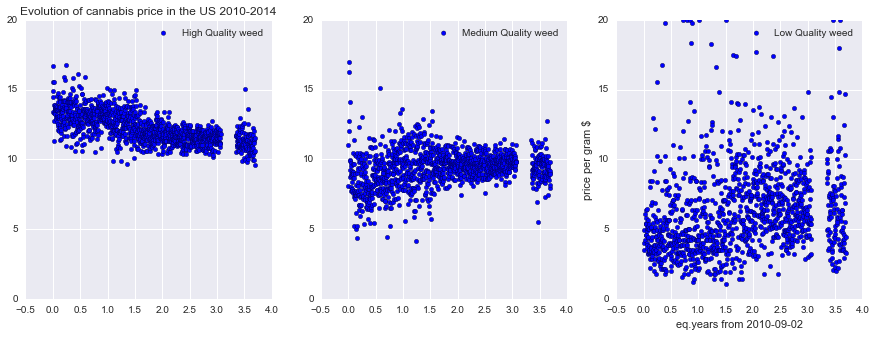

In [38]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.title('Evolution of cannabis price in the US 2010-2014')

plt.scatter(groupy.ix["high"].years,groupy.ix["high"].ppg)
plt.legend(('High Quality weed',))
plt.ylim(0,20)

plt.subplot(132)
plt.scatter(groupy.ix["medium"].years,groupy.ix["medium"].ppg)
plt.legend(('Medium Quality weed',))
plt.ylim(0,20)

plt.subplot(133)
plt.scatter(groupy.ix["low"].years,groupy.ix["low"].ppg)
plt.legend(('Low Quality weed',))
plt.ylim(0,20)

plt.xlabel('eq.years from 2010-09-02')
plt.ylabel('price per gram $')

## Linear Regression

In [39]:
def compute_regression(quality):
    Data = group_dict[quality]
    X = Data[["years"]].values
    y = Data[["ppg"]].values

    regr = linear_model.LinearRegression()
    model = regr.fit(X,y)
    regression = {"quality": q, 'model': model}
    return (q,model,model.score(X,y))

regression_results = []

for q in quality:
    q,model,score = compute_regression(q)
  
    regression_results.append((q, model.coef_[0][0],model.intercept_[0],score))

regression_results= pd.DataFrame(regression_results,columns=['quality','coef_','intercept_','r2'])
regression_results

,quality,coef_,intercept_,r2
0,high,-0.708207,13.449644,0.444078
1,medium,0.283193,8.879130,0.049905
2,low,0.568345,5.361599,0.029596


(0, 20)

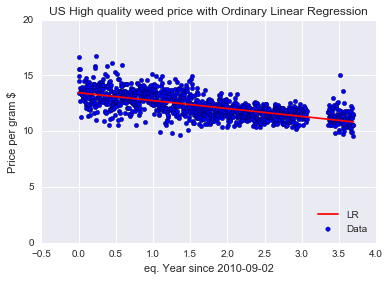

In [40]:
High = group_dict['high']
_,model,_ = compute_regression('high')
plt.plot(High.years,model.predict(High[["years"]].values),color='r')
plt.scatter(groupy.ix["high"].years,groupy.ix["high"].ppg)
plt.legend(('LR','Data',),loc=4)
plt.xlabel("eq. Year since 2010-09-02")
plt.ylabel('Price per gram $')
plt.title('US High quality weed price with Ordinary Linear Regression')
plt.ylim(0,20)


### Reindex the dataframes with missing dates


In [41]:
dates = pd.date_range(transactions.date.min(),transactions.date.max())
for q in quality:
    group_dict[q] = group_dict[q].reindex(dates)
    
nullos = group_dict['high'][group_dict['high'].ppg.isnull()]
print "% of missing dates for high quality weed : ",np.round(nullos.shape[0]/group_dict['high'].shape[0]*100,decimals=2)


% of missing dates for high quality weed :  8.07


### Using rolling mean

(array([ 734077.,  734258.,  734442.,  734624.,  734808.,  734989.,
         735173.,  735354.]), <a list of 8 Text xticklabel objects>)

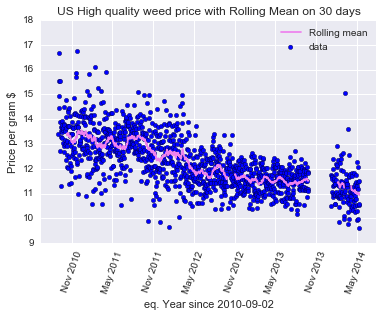

In [42]:
 for q in quality:
        group_dict[q]['rolling_mean']= group_dict[q].ppg.rolling(30).mean()
        
df = group_dict['high']
plt.plot(df.index,df.rolling_mean,'violet')
plt.scatter(df.index,df.ppg)
plt.xlabel("eq. Year since 2010-09-02")
plt.ylabel('Price per gram $')
plt.title('US High quality weed price with Rolling Mean on 30 days')
plt.legend(('Rolling mean', "data",))
plt.xticks(rotation=70)

### Using Exponentially-weighted moving average

(array([ 734077.,  734258.,  734442.,  734624.,  734808.,  734989.,
         735173.,  735354.]), <a list of 8 Text xticklabel objects>)

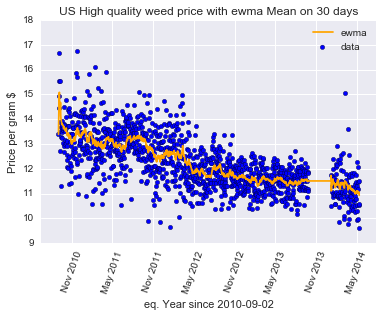

In [43]:
 for q in quality:
        group_dict[q]['ewma']= group_dict[q].ppg.ewm(span=30).mean()
  
        
df = group_dict['high']
plt.plot(df.index,df.ewma,'orange')
plt.scatter(df.index,df.ppg)
plt.xlabel("eq. Year since 2010-09-02")
plt.ylabel('Price per gram $')
plt.title('US High quality weed price with ewma Mean on 30 days')
plt.legend(('ewma', "data",))
plt.xticks(rotation=70)

###  Replace NaN with (ewma  + resampled residuals) in ppg

In [44]:
for q in quality:
    resid = (group_dict[q].ppg-group_dict[q].ewma).dropna()
    resample_data = np.random.choice(resid, replace=True)
    fake_data = group_dict[q].ewma + resample_data
    group_dict[q].ppg.fillna(fake_data,inplace =True)


### Autocorrelation

In [45]:
#simple example for a given lag period:
def SerialCorrelation(series,lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = np.corrcoef(xs,ys)
    return corr

corry = SerialCorrelation(groupy.ix['high'].ppg)

In [46]:
# recompute EWMA (don't fucking ask me why)

In [47]:
for q in quality:
    
    group_dict[q].ewma = group_dict[q].ppg.ewm(span=30).mean()
    group_dict[q]['residual'] = group_dict[q].ppg - group_dict[q].ewma

In [48]:
# implementation for all lags :
def compute_acf_and_resample(group_dict):
    
    acf_list =[]
    nlags = 40
    resampling_size = 1001

    for q in quality:
        df = group_dict[q]
        acf = smtsa.acf(df.residual, nlags=nlags,unbiased=True)
        acf_list.append(acf)



    # trick : resample high quality data , iterate to compute a correlation distribution for each lag
    acf_resampling = []
    
    for _ in range(resampling_size):
        sample = np.random.choice(group_dict['high'].residual,len(group_dict['high'].residual),replace=True)
        acf = smtsa.acf(sample,nlags=nlags, unbiased=True)
        acf_resampling.append(np.abs(acf)[1:])

    #then compute the 97.5% quantile for all sample per lag value
    df_resampling = pd.DataFrame(acf_resampling)
    
    resampling_percentiles_97_5 = df_resampling.quantile(.975,axis=0)
    resampling_data = {}
    resampling_data['percentile_high'] = resampling_percentiles_97_5
    resampling_data['range_plot'] = range(1,nlags+1)
   
    
    
    return acf_list,nlags,resampling_data

In [49]:
def plot_acf_resampling(acf_list,nlags,resampling_data):
    plt.plot(range(nlags)[1:],acf_list[1][1:nlags],color='#123456')
    plt.plot(range(nlags)[1:],acf_list[0][1:nlags],color='#339999')
    plt.plot(range(nlags)[1:],acf_list[2][1:nlags],color='#19d2d5')
    

    plt.fill_between(resampling_data['range_plot'],resampling_data['percentile_high'],-resampling_data['percentile_high'],color='#e5b5c9')
    plt.title('Correlation with different lags values')
    plt.legend(('High','Medium','Low','97.5% CI'))
    plt.xlabel('Lag(days)')
    plt.ylabel('correlation on residual (ppg - ewma)')

    

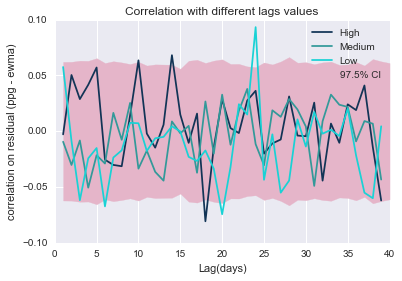

In [50]:
acf_list,nlags,resample_data = compute_acf_and_resample(group_dict)
plot_acf_resampling(acf_list,nlags,resample_data)

###  Add weekly seasonality

In [51]:
fake_groupe_dict={}

for key, df in group_dict.iteritems():
    
    fake_df = df.copy()
    
    friday_saturday = (fake_df.index.dayofweek==4) | (fake_df.index.dayofweek==5)
    fake_df.ppg[friday_saturday] += np.random.uniform(0,2,friday_saturday.sum())
    fake_df.ewma = fake_df.ppg.ewm(span=30).mean()
    fake_df.residual = fake_df.ppg - fake_df.ewma
    fake_groupe_dict[key] = fake_df
    
    

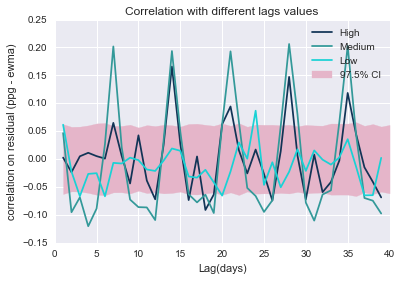

In [52]:
## reploplot with fake data on friday and saturday

acf_list,nlags,resample_data = compute_acf_and_resample(fake_groupe_dict)

plot_acf_resampling(acf_list,nlags,resample_data)
